In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
from PIL import Image
import numpy as np
import cv2


In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
# Carica il train_set (modifica in base alla posizione del tuo file)
train_set = unpickle('train')

# Estrai il nome dei file e i dati delle immagini
filenames = [f.decode('utf-8') for f in train_set[b'filenames']]  # Decodifica da byte a stringa


images_data = train_set[b'data']  # Supponiamo che le immagini siano in un array NumPy

# Crea una classe Dataset personalizzata
class CustomDataset(Dataset):
    def __init__(self, filenames, images_data, transform=None):
        self.filenames = filenames # nomi delle immagini
        self.images_data = images_data # nomi dei file 
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Carica l'immagine dal dataset
        img_data = self.images_data[idx]
        img = np.array(img_data, dtype=np.uint8).reshape(3, 32, 32)  # (C, H, W) -> RGB, adatta la forma a seconda del tuo caso

       
        img = Image.fromarray(np.transpose(img, (1, 2, 0)))  # Cambia l'ordine (H, W, C) a (C, H, W)

       
        if self.transform:
            img = self.transform(img)

        return img, self.filenames[idx]

# Definisci le trasformazioni, ad esempio: ridimensionamento, normalizzazione, ecc.
transform = transforms.Compose([
    transforms.ToTensor(),  # Converte l'immagine in un tensor
  #  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizzazione tipica
])


dataset = CustomDataset(filenames=filenames, images_data=images_data, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle = False)

Checking the color frequencies of the images with the bins created for training

In [4]:
def process_images(images_data, bin_count=50):
    """
    Converts images from RGB to YUV, bins the U and V channels, 
    and concatenates all data into a single tensor.

    Args:
        images_data (list): List of flattened RGB images.
        bin_count (int): Number of bins for U and V channels.

    Returns:
        torch.Tensor: Concatenated YUV data.
        torch.Tensor: Concatenated U bins.
        torch.Tensor: Concatenated V bins.
    """
    bins = np.linspace(0, 1, bin_count + 1)  # Define bin edges

    def bin_labels(values):
        return np.digitize(values, bins) - 1  # Map values to bin indices

    all_Y = []
    all_U_binned = []
    all_V_binned = []

    for img_data in images_data:
        img_rgb = np.array(img_data, dtype=np.uint8).reshape(3, 32, 32)
        img_rgb = np.transpose(img_rgb, (1, 2, 0))  # Convert to HxWxC format

        # Convert RGB to LUV (YUV-like)
        image_yuv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Luv)

        # Normalize Y to [0,1]
        Y_channel = image_yuv[:, :, 0] / 255.0
        U_channel = image_yuv[:, :, 1] / 255.0
        V_channel = image_yuv[:, :, 2] / 255.0

        # Bin U and V channels
        U_binned = bin_labels(U_channel)
        V_binned = bin_labels(V_channel)

        # Store results
        all_Y.append(Y_channel[np.newaxis, :, :])  # Add channel dim
        all_U_binned.append(U_binned)
        all_V_binned.append(V_binned)

    # Convert to PyTorch tensors
    all_Y = np.array(np.stack(all_Y), dtype=np.float32)  # Shape: (N, 1, 32, 32)
    all_U_binned = np.array(np.stack(all_U_binned), dtype=np.long)  # (N, 32, 32)
    all_V_binned = np.array(np.stack(all_V_binned), dtype=np.long)  # (N, 32, 32)

    return all_Y, all_U_binned, all_V_binned


In [5]:
all_Y, all_U_binned, all_V_binned = process_images(images_data, bin_count=50)

Show the bins in the UV map

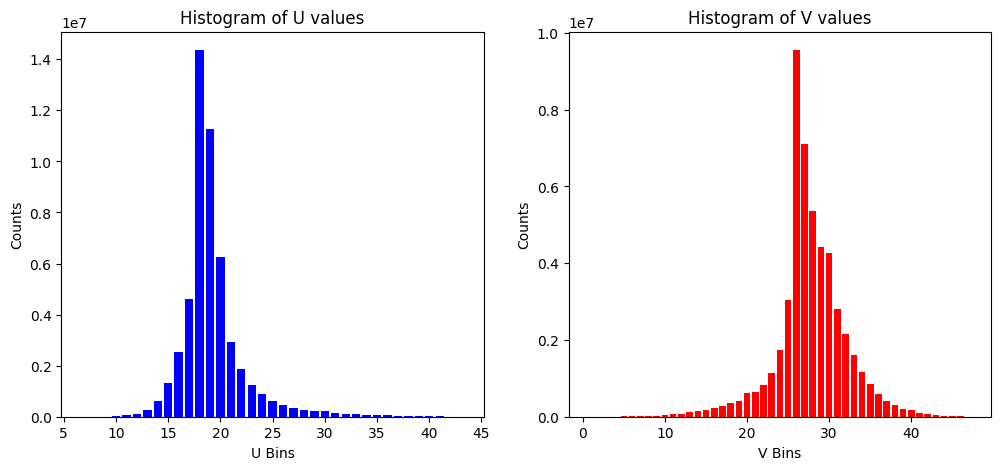

In [6]:
def plot_uv_histogram_pytorch(all_U_binned, all_V_binned, bin_count=50):
    """
    Creates a histogram of binned U and V values using PyTorch.
    """
    U_flat = all_U_binned.flatten()  # Flatten tensor
    V_flat = all_V_binned.flatten()

    # Compute 2D histogram
    #hist, x_edges, y_edges = np.histogram2d(U_flat, V_flat, bins=bin_count, range=[[0, bin_count], [0, bin_count]])
    bins_u, counts_u = np.unique(U_flat,return_counts=True)[0],np.unique(all_U_binned.flatten(),return_counts=True)[1]
    bins_v, counts_v = np.unique(V_flat,return_counts=True)[0],np.unique(all_V_binned.flatten(),return_counts=True)[1]

    # Plot heatmap
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].bar(bins_u, counts_u, color='blue')
    ax[0].set_xlabel("U Bins")
    ax[0].set_ylabel("Counts")
    ax[0].set_title("Histogram of U values")

    ax[1].bar(bins_v, counts_v, color='red')
    ax[1].set_xlabel("V Bins")
    ax[1].set_ylabel("Counts")
    ax[1].set_title("Histogram of V values")

    plt.show()
# Example usage
plot_uv_histogram_pytorch(all_U_binned, all_V_binned, bin_count=50)



In [7]:
max_V = np.unique(all_V_binned.flatten(),return_counts=True)[0][np.argmax(np.unique(all_V_binned.flatten(),return_counts=True)[1])]
max_U = np.unique(all_U_binned.flatten(),return_counts=True)[0][np.argmax(np.unique(all_U_binned.flatten(),return_counts=True)[1])]

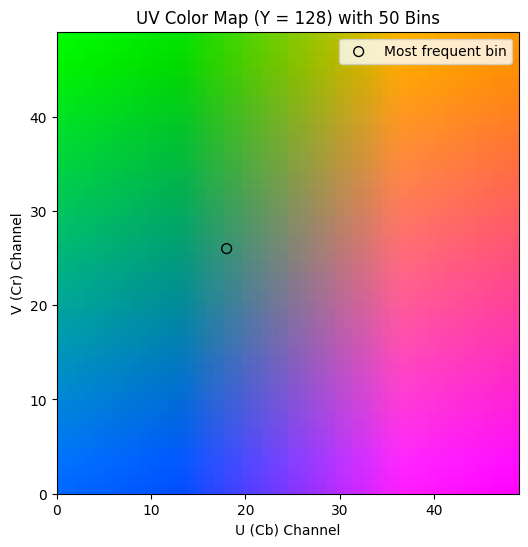

In [23]:
# Define the number of bins
num_bins = 50
Y_fixed=128

# Create binned U and V values
U_bins = np.linspace(-128, 127, num_bins)
V_bins = np.linspace(-128, 127, num_bins)

# Create an image grid for binned U and V values
UV_binned_grid = np.zeros((num_bins, num_bins, 3), dtype=np.uint8)

# Iterate over the binned U, V values and convert to RGB
for i, U in enumerate(U_bins):
    for j, V in enumerate(V_bins):
        # Convert YUV to BGR
        YUV_color = np.array([Y_fixed, U + 128, V + 128], dtype=np.uint8)
        BGR_color = cv2.cvtColor(YUV_color.reshape(1, 1, 3), cv2.COLOR_YUV2BGR)
        UV_binned_grid[j, i] = BGR_color  # Assign to image (swapping j, i)

# Display the binned UV color map
plt.figure(figsize=(6, 6))
plt.scatter(max_U,max_V,s=50, facecolors='none', edgecolors='black',label="Most frequent bin")
plt.imshow(UV_binned_grid, extent=[0, num_bins - 1, 0, num_bins - 1])
plt.xlabel("U (Cb) Channel")
plt.ylabel("V (Cr) Channel")
plt.title(f"UV Color Map (Y = 128) with {num_bins} Bins")
plt.legend()
plt.grid(False)

plt.show()

Creating the probability distribution

In [9]:
#
bins_u, counts_u = np.unique(all_U_binned.flatten(),return_counts=True)[0],np.unique(all_U_binned.flatten(),return_counts=True)[1]
bins_v, counts_v = np.unique(all_V_binned.flatten(),return_counts=True)[0],np.unique(all_V_binned.flatten(),return_counts=True)[1]

total_pixel = np.sum(counts_u)
full_bins = np.arange(0, num_bins + 1)

# Create a dictionary mapping existing bins to their counts
bin_count_dict_u = dict(zip(bins_u, counts_u))
bin_count_dict_v = dict(zip(bins_v, counts_v))

# Ensure all bins have a count (default to 0 for missing bins)
full_counts_u = np.array([bin_count_dict_u.get(b, 0) for b in full_bins])
full_counts_v = np.array([bin_count_dict_v.get(b, 0) for b in full_bins])

probs_u = full_counts_u / np.sum(full_counts_u)
probs_v = full_counts_v / np.sum(full_counts_v)

'''
def u_distrib(bin_count=50):
    return np.random.choice(full_bins, bin_count,p=probs_u)

def v_distrib(bin_count=50):
    return np.random.choice(full_bins, bin_count,p=probs_v)
'''

'\ndef u_distrib(bin_count=50):\n    return np.random.choice(full_bins, bin_count,p=probs_u)\n\ndef v_distrib(bin_count=50):\n    return np.random.choice(full_bins, bin_count,p=probs_v)\n'

In [10]:
probs_u

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.75781250e-07,
       2.94335938e-05, 1.45957031e-04, 4.56601562e-04, 9.94707031e-04,
       2.17863281e-03, 5.08570313e-03, 1.20534570e-02, 2.59479297e-02,
       4.98515625e-02, 8.99340820e-02, 2.80495605e-01, 2.20355156e-01,
       1.22186172e-01, 5.72833594e-02, 3.63760742e-02, 2.45589648e-02,
       1.70139258e-02, 1.19357617e-02, 8.72634766e-03, 6.61492187e-03,
       5.18248047e-03, 4.19519531e-03, 4.09158203e-03, 2.76226562e-03,
       2.33486328e-03, 2.01308594e-03, 1.66167969e-03, 1.41462891e-03,
       1.15220703e-03, 9.31035156e-04, 7.35214844e-04, 5.55703125e-04,
       4.25996094e-04, 1.95058594e-04, 9.36328125e-05, 3.08398437e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

Compute weights for U and V binned together

In [20]:
UV_binned_grid = np.zeros((num_bins, num_bins,2), dtype=np.uint8)

# Iterate over the binned U, V values and convert to RGB
for i, U in enumerate(U_bins):
    for j, V in enumerate(V_bins):
        UV_binned_grid[i, j] = np.array([U,V], dtype=np.uint8)

In [ ]:


def compute_weights(prob_dist, lambda_param=0.5):
    """
    Compute class rebalancing weights based on the pixel color distribution.
    """
    Q = len(prob_dist)**2  # Number of quantized bins
    uniform_dist = torch.ones(Q) / Q  # Uniform distribution

    # Compute the weighted probability
    smoothed_prob = (1 - lambda_param) * prob_dist + lambda_param * uniform_dist
    weights = 1.0 / smoothed_prob  # Inverse probability
    weights /= weights.sum()  # Normalize
    
    return weights

def soft_encode(y_true, bins, sigma=5):
    """
    Perform soft encoding by distributing weights across the nearest neighbors.
    - y_true: Ground truth colors (Nx2)
    - bins: Discrete ab bins (Qx2)
    - sigma: Gaussian kernel standard deviation
    """
    N = y_true.shape[0]
    print(N)
    Q = UV_binned_grid.shape[0]
    print(Q)
    
    # Compute Euclidean distance between each pixel and bin
    dist = torch.cdist(y_true, bins)  # Shape: (N, Q)
    
    # Find the 5 nearest neighbors
    knn_indices = torch.topk(-dist, k=5, dim=1).indices  # (N, 5)
    
    # Compute Gaussian weights
    knn_dist = torch.gather(dist, 1, knn_indices)  # Distances to 5 nearest neighbors
    weights = torch.exp(-knn_dist ** 2 / (2 * sigma ** 2))
    weights /= weights.sum(dim=1, keepdim=True)  # Normalize
    
    # Create soft-encoded one-hot vectors manually
    soft_labels = torch.zeros(N, Q, device=y_true.device)
    
    for i in range(N):
        soft_labels[i, knn_indices[i]] += weights[i]
    
    return soft_labels



lambda_param = 0.5
weights = compute_weights(torch.Tensor(probs_u), lambda_param)

'''
# Fake color data (ground truth and bins)
y_true = torch.randn(num_samples, 2)  # Ground truth colors
bins = torch.randn(num_bins, 2)  # Quantized ab bins

# Soft encoding
soft_labels = soft_encode(y_true, bins, sigma=5)
'''


RuntimeError: The size of tensor a (51) must match the size of tensor b (6765201) at non-singleton dimension 0

In [12]:
weights.shape

torch.Size([51])

In [ ]:
b

In [16]:
bins.shape

torch.Size([51, 2])

In [ ]:

whole_labels = []
for img_data in images_data:
    img_rgb = np.array(img_data, dtype=np.uint8).reshape(3, 32, 32)
    img_rgb = np.transpose(img_rgb, (1, 2, 0))  # Convert to HxWxC format

    # Convert RGB to LUV (YUV-like)
    image_yuv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Luv)
    
    # Normalize Y to [0,1]
    Y_channel = image_yuv[:, :, 0] / 255.0
    U_channel = image_yuv[:, :, 1] / 255.0
    V_channel = image_yuv[:, :, 2] / 255.0

    bins = torch.Tensor([np.linspace(0, 1, num_bins),np.linspace(0, 1, num_bins)]).T

    uv_channels = torch.Tensor([U_channel,V_channel]).T

    soft_labels = soft_encode(uv_channels, bins, sigma=4)
    print("Shape soft labels: ",soft_labels.shape)
    #print("Max value: ",np.max(soft_labels))
    whole_labels.append(soft_labels)

Shape soft labels:  torch.Size([32, 51])
Shape soft labels:  torch.Size([32, 51])
Shape soft labels:  torch.Size([32, 51])
Shape soft labels:  torch.Size([32, 51])
Shape soft labels:  torch.Size([32, 51])
Shape soft labels:  torch.Size([32, 51])
Shape soft labels:  torch.Size([32, 51])
Shape soft labels:  torch.Size([32, 51])
Shape soft labels:  torch.Size([32, 51])
Shape soft labels:  torch.Size([32, 51])
Shape soft labels:  torch.Size([32, 51])
Shape soft labels:  torch.Size([32, 51])
Shape soft labels:  torch.Size([32, 51])
Shape soft labels:  torch.Size([32, 51])
Shape soft labels:  torch.Size([32, 51])
Shape soft labels:  torch.Size([32, 51])
Shape soft labels:  torch.Size([32, 51])
Shape soft labels:  torch.Size([32, 51])
Shape soft labels:  torch.Size([32, 51])
Shape soft labels:  torch.Size([32, 51])
Shape soft labels:  torch.Size([32, 51])
Shape soft labels:  torch.Size([32, 51])
Shape soft labels:  torch.Size([32, 51])
Shape soft labels:  torch.Size([32, 51])
Shape soft label

KeyboardInterrupt: 